In [6]:
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps, project_to_plane
from utils.combine_tools import apply_qc, to_str_intlike
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
import statsmodels.api as sm
from aind_ephys_utils import align
import k3d
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
target_folder = '/root/capsule/scratch/manuscript/F_ephys_beh_action&outcome/example_figs'

# Stay vs Swtich example


In [8]:
examples = [('behavior_751004_2024-12-21_13-28-28', 22), 
            ('behavior_751766_2025-02-11_11-53-38', 285),
            ('behavior_751766_2025-02-13_11-31-21', 144),
            ('behavior_754897_2025-03-13_11-20-42', 54),
            ('behavior_758017_2025-02-04_11-57-38', 5),
            ('behavior_758017_2025-02-07_14-11-08', 17),
            ('behavior_761038_2025-04-18_12-37-39', 12),
            ('behavior_ZS061_2021-03-20_18-03-26', 'TT3_SS_01'),
            ('behavior_ZS061_2021-03-28_16-35-51', 'TT1_SS_01'),
            ('behavior_ZS061_2021-04-01_16-38-03', 'TT1_SS_01'),
            ('behavior_ZS061_2021-04-08_18-01-30', 'TT4_SS_01'), 
            ('behavior_ZS061_2021-03-28_16-35-51', 'TT1_SS_01'),
            ('behavior_ZS061_2021-03-20_18-03-26', 'TT3_SS_01')]

In [9]:
custom_cmap = LinearSegmentedColormap.from_list('switch', [(0.0, 'green'), (0.5, 'white'), (1.0, 'purple')])

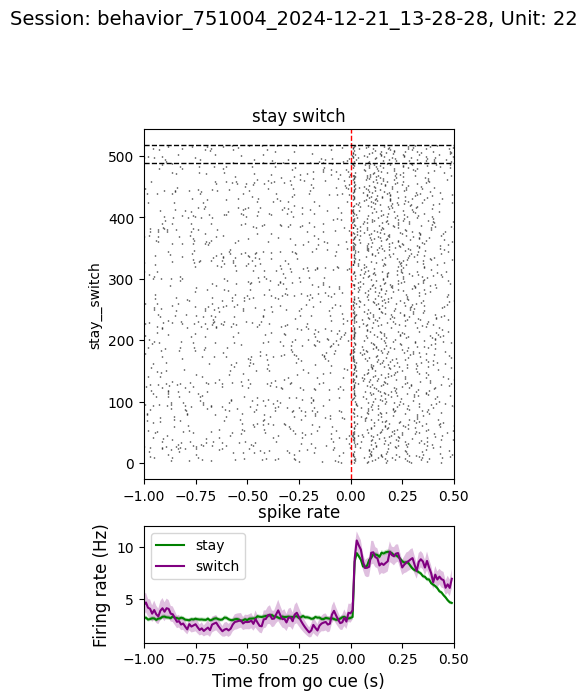

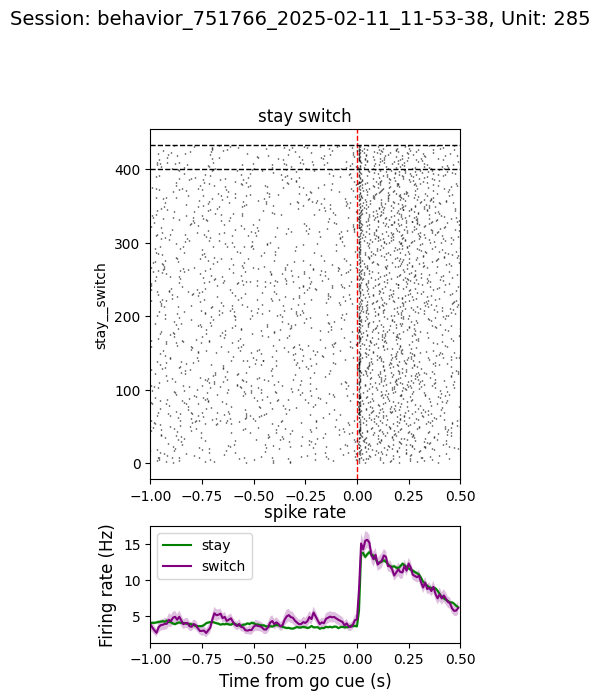

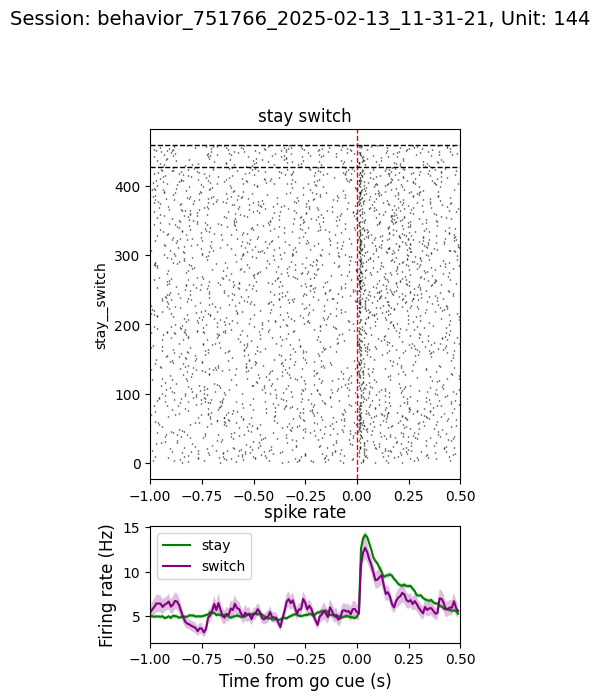

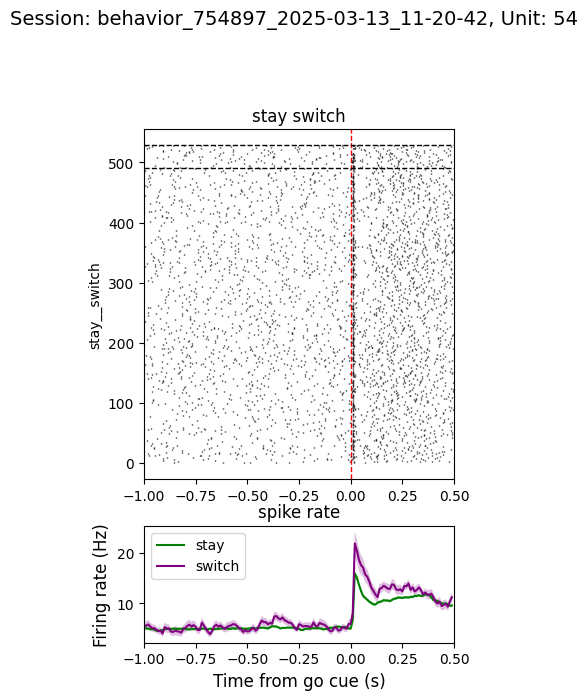

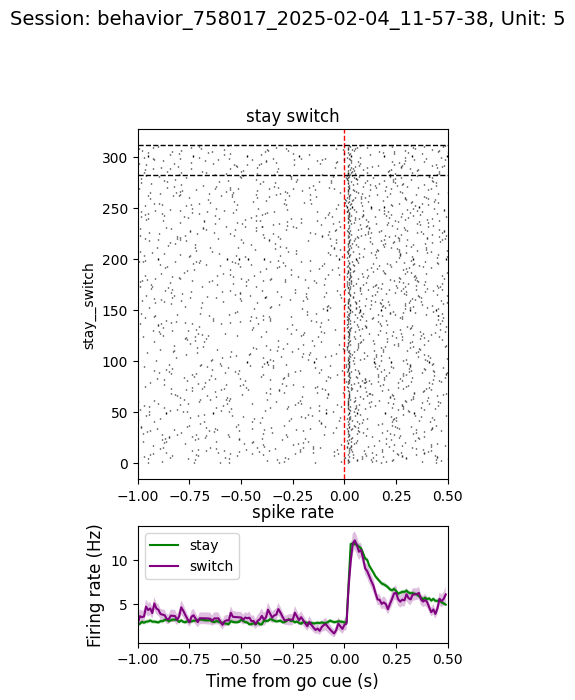

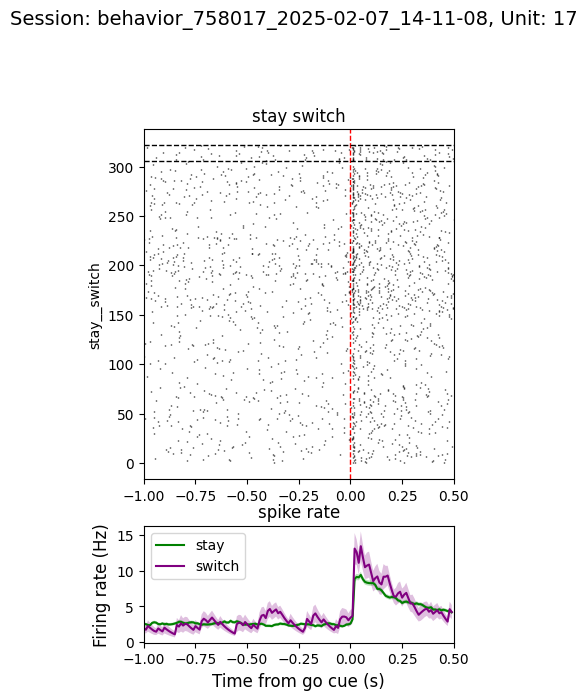

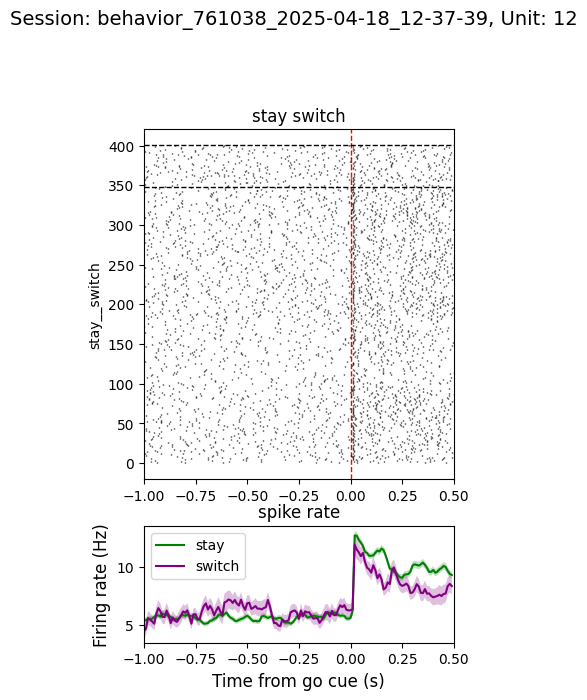

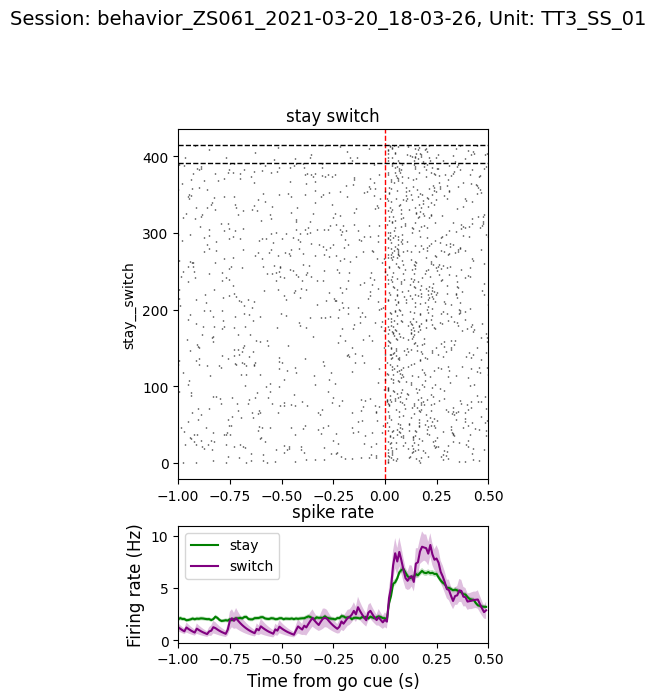

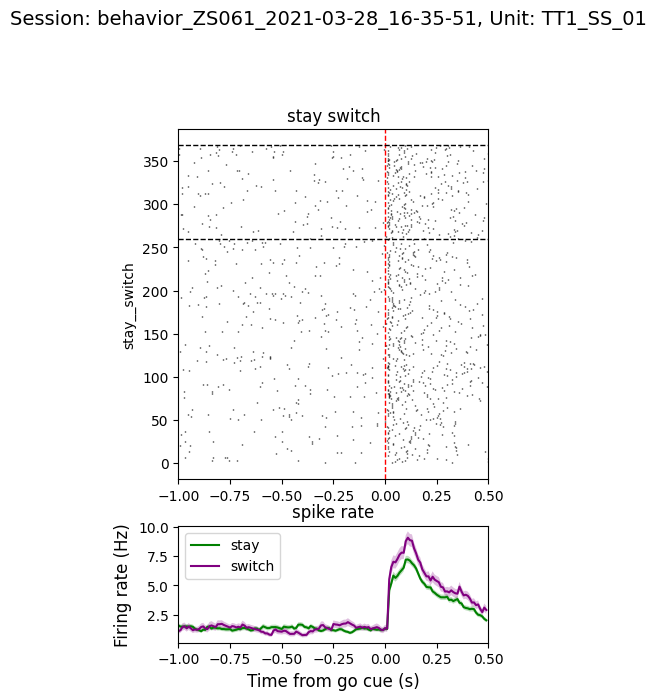

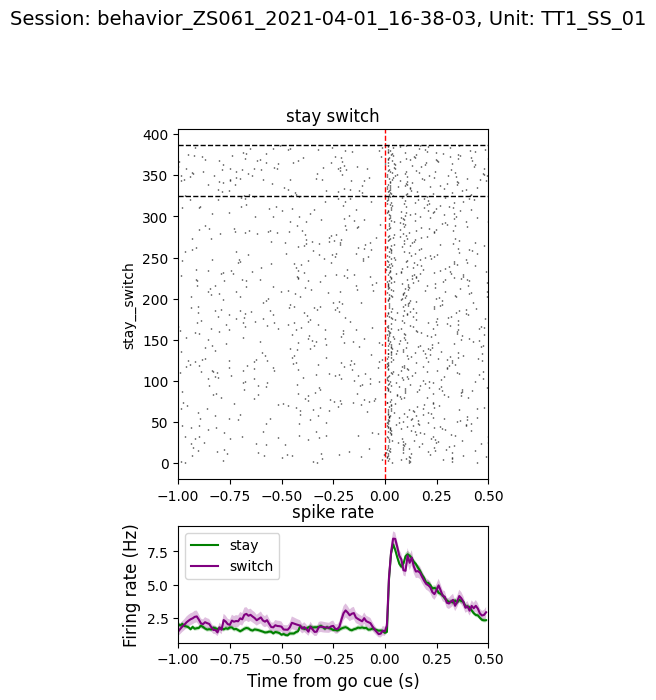

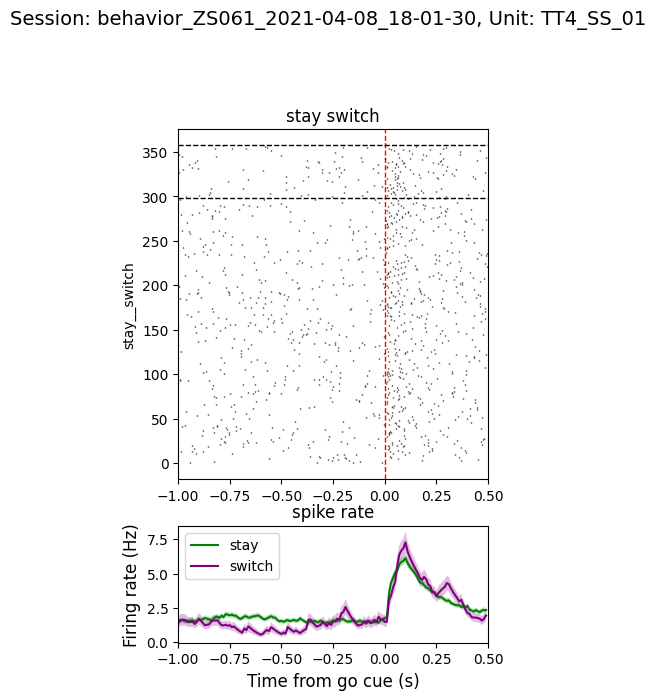

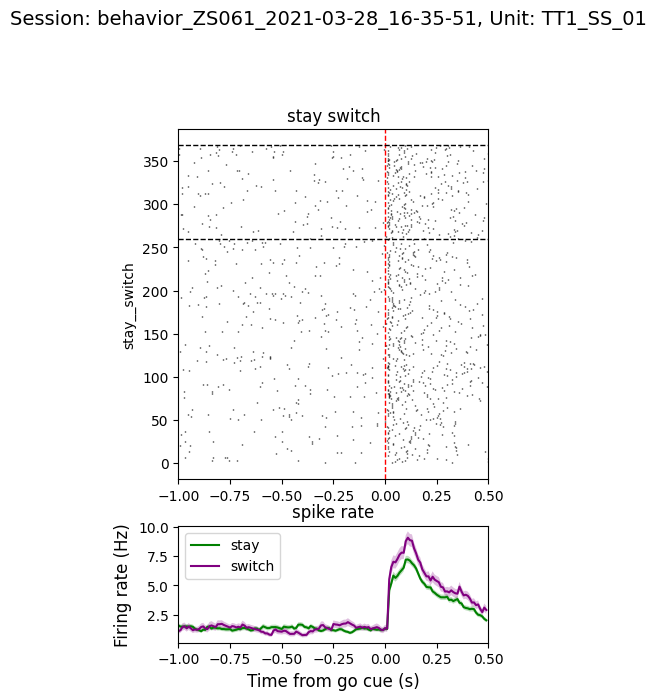

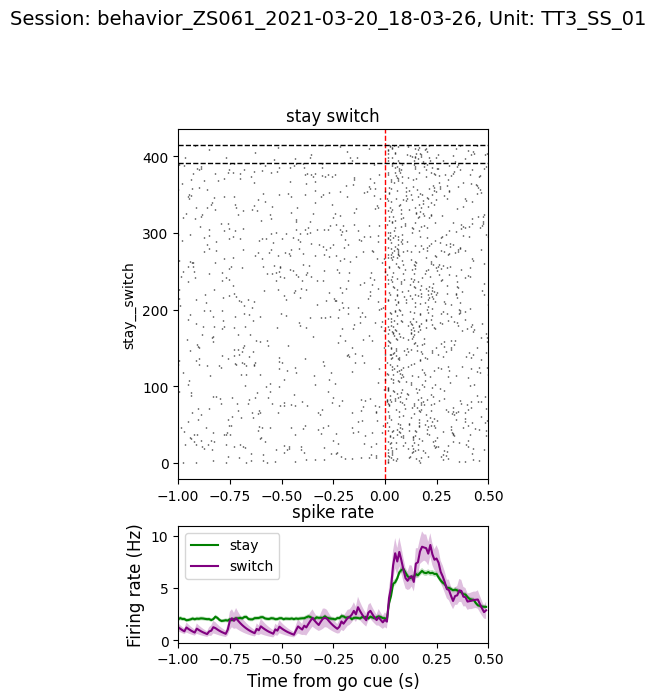

In [10]:
for curr_ind, curr_example in enumerate(examples):
    session = curr_example[0]
    unit_id = curr_example[1]
    session_df = get_session_tbl(session)
    session_tbl = makeSessionDF(session)
    unit_tbl = get_unit_tbl(session, data_type='curated')
    spike_times = unit_tbl.loc[unit_tbl['unit_id'] == unit_id, 'spike_times'].values[0] 
    unit_drift = load_drift(session, unit_id, data_type='curated')
    session_df_curr = session_tbl.copy()
    spike_times_curr = spike_times.copy()
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
    fig = plt.figure(figsize=(4,12))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.4)
    fig, ax1, ax2 = plot_raster_rate(spike_times_curr,session_df_curr['go_cue_time'].values, 
                                session_df_curr['svs'], [-1, 0.5, 2], ['stay', 'switch'], 
                                custom_cmap, fig, gs[0], kernel = True, tb=-1, tf=0.5, tau_decay=0.08, tau_rise=0.001, step_size= 0.01)
    ax2.set_ylabel('Firing rate (Hz)', fontsize=12)
    ax2.set_xlabel('Time from go cue (s)', fontsize=12)
    plt.suptitle(f'Session: {session}, Unit: {unit_id}', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(target_folder, f'switch-stay_{session}_{unit_id}.pdf'))
    plt.savefig(os.path.join(target_folder, f'switch-stay_{session}_{unit_id}.svg'))

# Miss vs Hit

In [11]:
examples = [('behavior_754897_2025-03-13_11-20-42', 26), 
            ('behavior_752014_2025-03-28_11-04-59', 27),
            ('behavior_751766_2025-02-14_11-37-11', 36),
            ('behavior_716325_2024-05-31_10-31-14', 87),
            ('behavior_ZS061_2021-04-30_17-06-18','TT4_SS_01'),
            ('behavior_ZS062_2021-03-27_19-15-29','TT4_SS_01'),
            ('behavior_ZS062_2021-04-02_19-08-52','TT7_SS_01'),
            ('behavior_ZS061_2021-03-29_17-48-18','TT5_SS_01'),
            ('behavior_ZS061_2021-03-29_17-48-18','TT4_SS_01'),
            ('behavior_ZS061_2021-03-22_17-35-53','TT4_SS_01'),
            ('behavior_ZS061_2021-03-23_16-08-12','TT4_SS_01')]

In [12]:
custom_cmap = LinearSegmentedColormap.from_list('hit', [(0.0, 'blue'), (0.5, 'white'), (1.0, 'orange')])

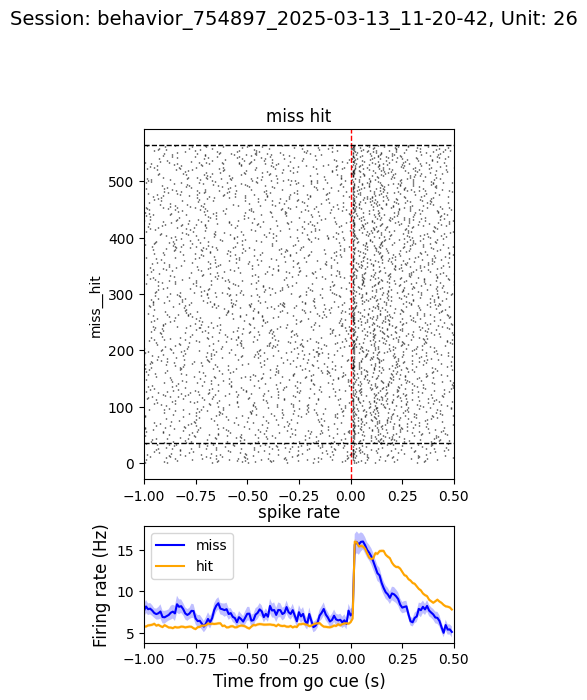

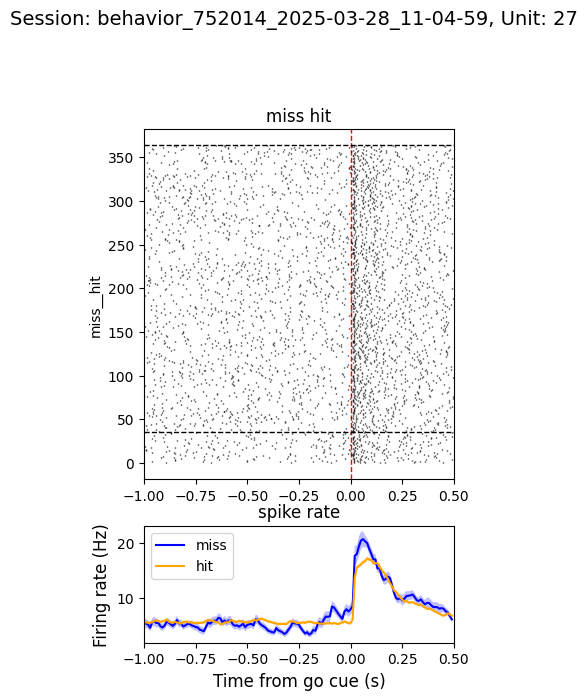

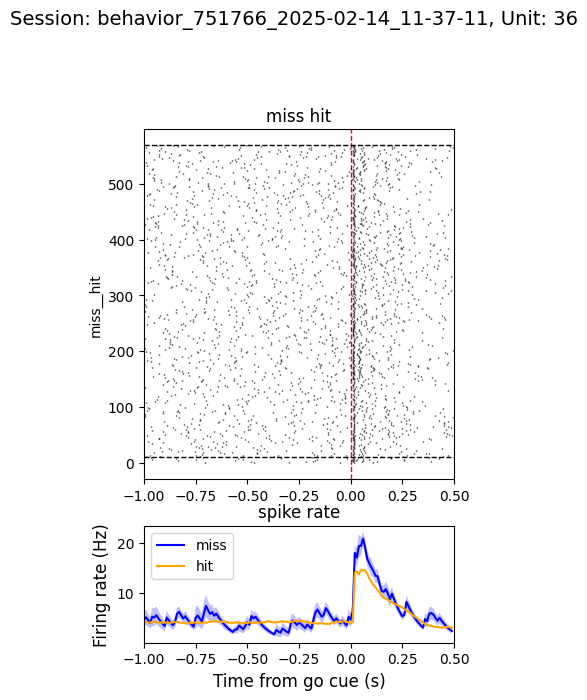

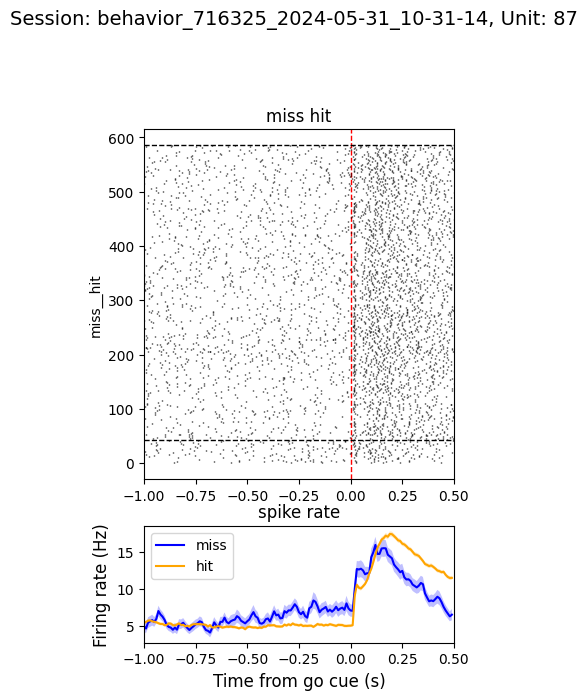

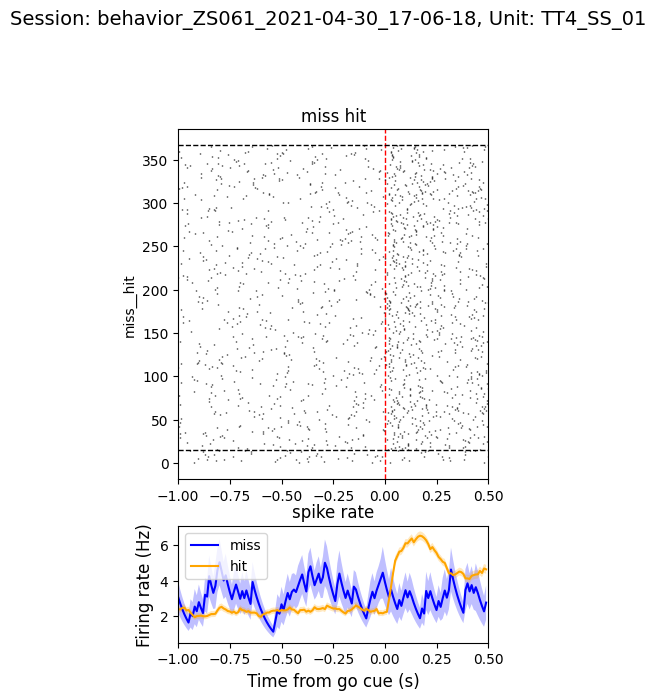

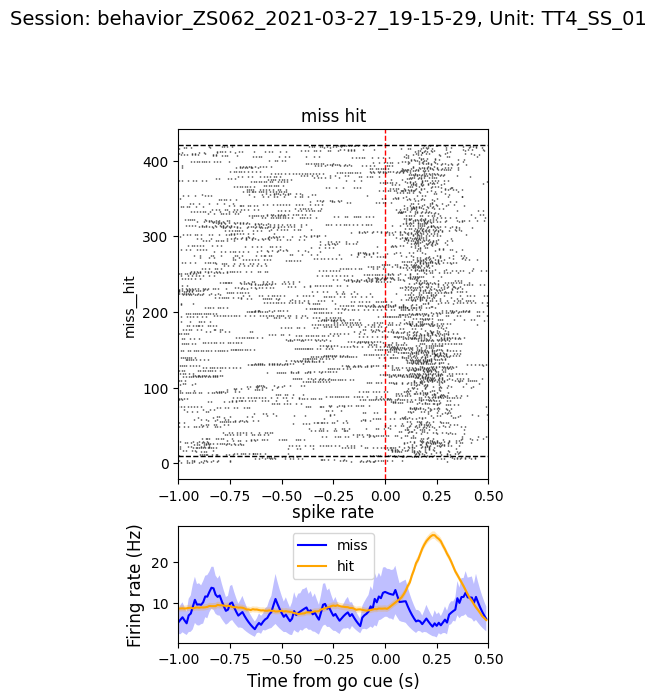

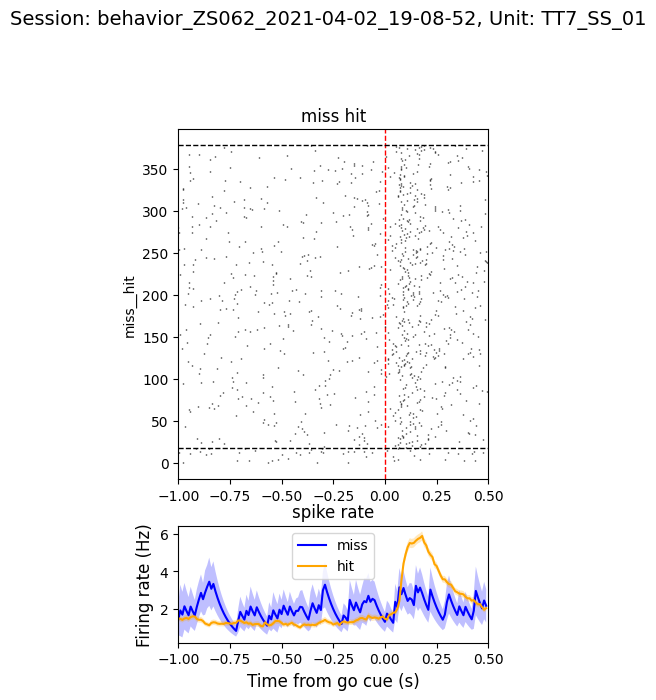

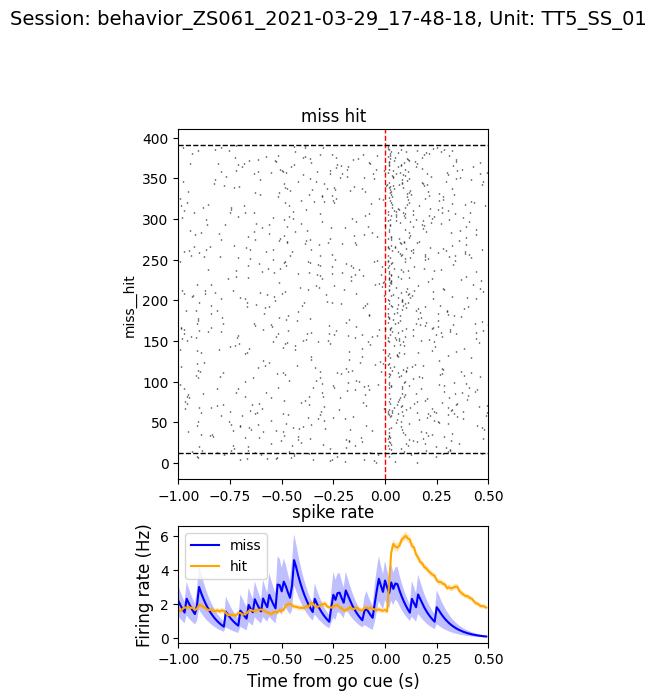

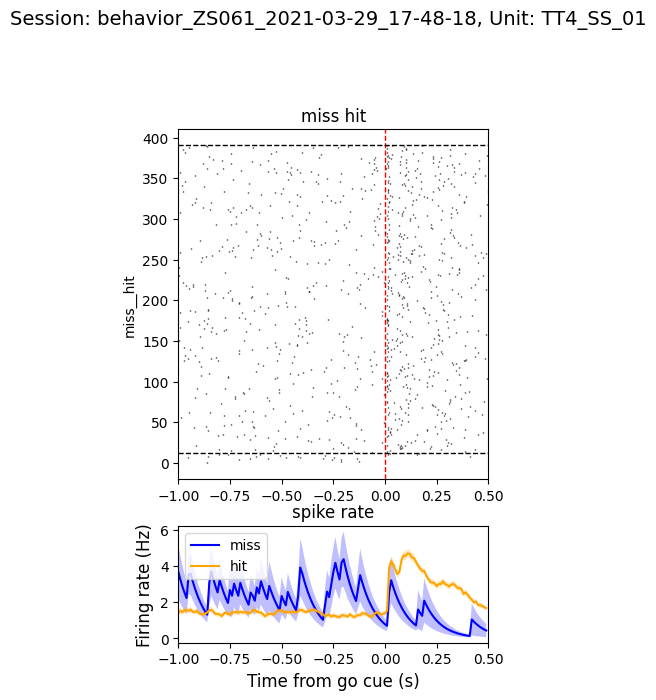

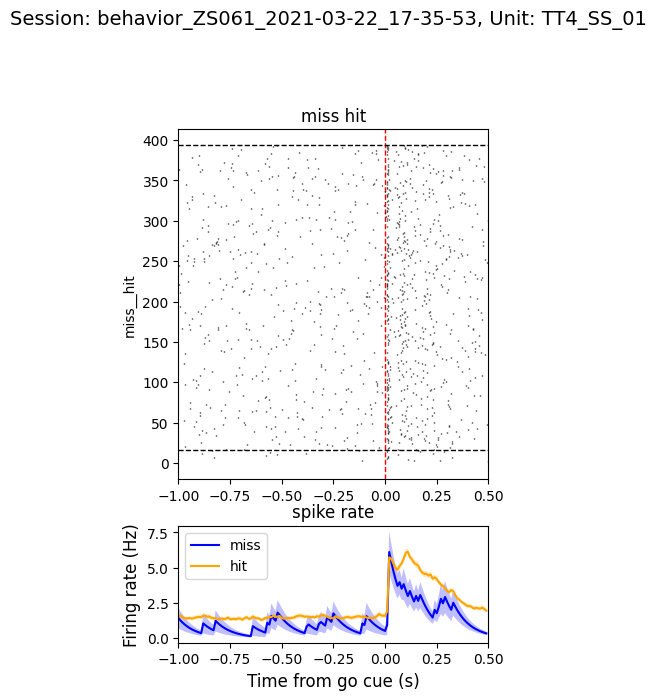

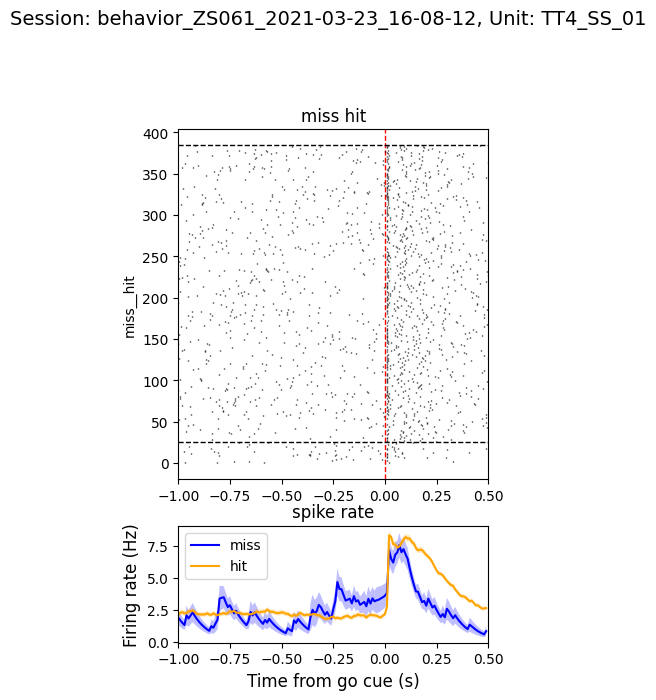

In [13]:
for curr_ind, curr_example in enumerate(examples):
    session = curr_example[0]
    unit_id = curr_example[1]
    session_df = get_session_tbl(session)
    unit_tbl = get_unit_tbl(session, data_type='curated')
    spike_times = unit_tbl.loc[unit_tbl['unit_id'] == unit_id, 'spike_times'].values[0] 
    unit_drift = load_drift(session, unit_id, data_type='curated')
    session_df_curr = session_df.copy()
    spike_times_curr = spike_times.copy()
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
    fig = plt.figure(figsize=(4,12))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.4)
    fig, ax1, ax2 = plot_raster_rate(spike_times_curr,session_df_curr['goCue_start_time'].values, 
                                session_df_curr['animal_response'].values!=2, [-1, 0.5, 2], ['miss', 'hit'], 
                                custom_cmap, fig, gs[0], kernel = True, tb=-1, tf=0.5, tau_decay=0.08, tau_rise=0.001, step_size= 0.01)
    ax2.set_ylabel('Firing rate (Hz)', fontsize=12)
    ax2.set_xlabel('Time from go cue (s)', fontsize=12)
    plt.suptitle(f'Session: {session}, Unit: {unit_id}', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(target_folder, f'hit-miss_{session}_{unit_id}.pdf'))
    plt.savefig(os.path.join(target_folder, f'hit-miss_{session}_{unit_id}.svg'))